## SEIR Simulation 

In [12]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
# load OD matrices
pkl_file = open('data/data_municipalities/od_municipalities.pkl', 'rb') # change to your desired directory
OD_matrices = pickle.load(pkl_file)
pkl_file.close()

print(OD_matrices.shape)

(84, 356, 356)
[[0.8 0.1 0.  ... 0.  0.  0. ]
 [0.1 0.8 0.1 ... 0.  0.  0. ]
 [0.  0.1 0.8 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.8 0.1 0. ]
 [0.  0.  0.  ... 0.1 0.8 0.1]
 [0.  0.  0.  ... 0.  0.1 0.8]]


In [14]:
#kommunenummer = pd.read_csv("data/data_municipalities/kommuner.csv", delimiter=",").drop_duplicates()
#kommunenummer = kommunenummer.sort_values("Kommunenr. 2020", ascending=True).reset_index()[["Kommunenr. 2020", "Kommunenavn 2020"]]
#kommunenummer.rename(columns={"Kommunenr. 2020": "kommune_id", "Kommunenavn 2020": "kommunenavn"}, inplace=True)
#kommunenummer.kommune_id = kommunenummer.kommune_id.astype(int)

# create population 
befolkningstall_kommuner = pd.read_csv("data/data_municipalities/Folkemengde_kommuner.csv", delimiter=";", skiprows=1)
kommune_id = []
kommune_navn = []
for id_name in befolkningstall_kommuner.region.str.split(" "):
    kommune_id.append(int(id_name[0]))
    kommune_navn.append(str(id_name[1]))
befolkningstall_kommuner["kommune_id"] = kommune_id
befolkningstall_kommuner["kommunenavn"] = kommune_navn

befolkningstall_kommuner = befolkningstall_kommuner[["kommune_id", "kommunenavn", "Befolkning per 1.1. (personer) 2020"]]
befolkningstall_kommuner = befolkningstall_kommuner.rename(columns={ "Befolkning per 1.1. (personer) 2020": "befolkning"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   kommune_id  356 non-null    int64
 1   befolkning  356 non-null    int64
dtypes: int64(2)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   kommune_id   356 non-null    int64 
 1   kommunenavn  356 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.7+ KB
None


In [15]:
befolkningstall_kommuner = pd.merge(befolkningstall_kommuner, kommunenummer, how='inner', on="kommune_id")
befolkningstall_kommuner = befolkningstall_kommuner.sort_values("kommune_id", ascending = True).reset_index()[["kommune_id","kommunenavn", "befolkning"]]
befolkningstall_kommuner

,kommune_id,kommunenavn,befolkning
0,301,OSLO,693494
1,1101,EIGERSUND,14811
2,1103,STAVANGER,143574
3,1106,HAUGESUND,37357
4,1108,SANDNES,79537
...,...,...,...
351,5440,BERLEVÅG,957
352,5441,TANA,2918
353,5442,NESSEBY,926
354,5443,BÅTSFJORD,2221


In [16]:
befolkningsarray = befolkningstall_kommuner.befolkning.to_numpy(dtype='float64')
pop = np.asarray([befolkningsarray for _ in range(84)])

In [17]:
print(len(befolkningsarray))

356


In [18]:
# Set up model 
%run virus-sim.py  # Call python files in same directory

r = OD_matrices.shape[0]  # Simulation period (e.g 84)
n = pop.shape[1]          # Number of counties (e.g 11)
N = sum(befolkningsarray) # Total population (e.g 5367580)
initialInd = [2]          # Initial index of counties infected
initial = np.zeros(n)
initial[initialInd] = 50  # Number of infected people in each of the initial counties infected

model = Param(R0=2.4, DE= 5.6 * 12, DI= 5.2 * 12, I0=initial, HospitalisationRate=0.1, HospitalIters=15*12) # multiply by 12 as one day consists of 12 2-hours periods 

In [19]:
# run simulation
%run virus-sim.py

alpha = np.ones(OD_matrices.shape)  # One == no quarantene influence. Multiplied by real flow.
iterations = 3000                   # Number of simulations
res = {}                            # Dictionary with results for different cases 
inf = 50                            # Number of random infections
res['baseline'] = seir(model, pop, OD_matrices, alpha, iterations, inf)


In [20]:
# Print hospitalized information
print("Max number of hospitalised people: ", int(res["baseline"][0][:,4].max()))
print("Day with max hospitalised people: ", int(res["baseline"][0][:,4].argmax()/12)) # Divide by

Max number of hospitalised people:  99452
Day with max hospitalised people:  27


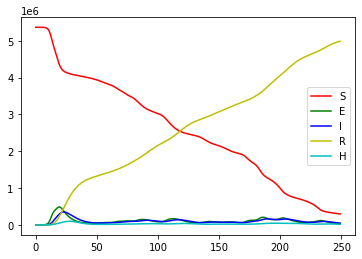

In [21]:
    def seir_plot(res):
        """ Plots the epidemiological curves
        Parameters:
            res: [3D matrix, compartment_id]
        """
        plt.plot(res[::12, 0], color='r', label='S')
        plt.plot(res[::12, 1], color='g', label='E')
        plt.plot(res[::12, 2], color='b', label='I')
        plt.plot(res[::12, 3], color='y', label='R')
        plt.plot(res[::12, 4], color='c', label='H')
        plt.legend()
        plt.show()
    
    seir_plot(res["baseline"][0])

## Spatial Visualisation

In [22]:
# import libraries
import pandas as pd
import geopandas as gpd
# import contextily as ctx # Is not installed with current .yml file 
import fiona as fi
from pyproj import CRS

In [23]:
kommuner = pd.read_json('data/data_municipalities/Basisdata_0000_Norge_25833_Kommuner_GEOJSON.geojson')
epsg_kommune = int(kommuner["administrative_enheter.kommune"].loc["crs"]["properties"]["name"].split(":")[1]) # epsg for kartverket sin data
crs_kommune = CRS.from_epsg(epsg_kommune)

In [66]:
# Load data and ensure right epsg
norge_geojson = gpd.read_file("data/data_municipalities/Basisdata_0000_Norge_25833_Kommuner_GEOJSON.geojson", layer='administrative_enheter.kommune')
norge_geojson.crs = {'init':f'epsg:{epsg_kommune}'}
norge_geojson.crs = crs_kommune
norge_geojson.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   objtype                   363 non-null    object  
 1   samiskforvaltningsomrade  350 non-null    object  
 2   lokalid                   363 non-null    object  
 3   navnerom                  363 non-null    object  
 4   versjonid                 363 non-null    object  
 5   datafangstdato            0 non-null      object  
 6   oppdateringsdato          363 non-null    object  
 7   datauttaksdato            363 non-null    object  
 8   opphav                    0 non-null      object  
 9   kommunenummer             363 non-null    object  
 10  navn                      363 non-null    object  
 11  geometry                  363 non-null    geometry
dtypes: geometry(1), object(11)
memory usage: 34.2+ KB


In [70]:
norge_geojson = norge_geojson.drop_duplicates(['kommunenummer']).reset_index()

In [71]:
#norge_geojson = norge_geojson[norge_geojson.duplicated(['kommunenummer'], keep=False)]
norge_geojson.sort_values(['kommunenummer'], ascending = True)

,level_0,index,objtype,samiskforvaltningsomrade,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,datauttaksdato,opphav,kommunenummer,navn,geometry
0,0,0,Kommune,False,172780,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100646,None,5031,"[ { ""navn"": ""Malvik"", ""rekkefolge"": """", ""sprak...","POLYGON ((292666.430 7030892.790, 292745.130 7..."
1,1,1,Kommune,False,172994,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100646,None,1532,"[ { ""navn"": ""Giske"", ""rekkefolge"": """", ""sprak""...","POLYGON ((15726.850 6973790.340, 19181.490 696..."
2,2,2,Kommune,False,173021,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100646,None,4636,"[ { ""navn"": ""Solund"", ""rekkefolge"": """", ""sprak...","POLYGON ((-83202.730 6837229.930, -84944.190 6..."
3,3,3,Kommune,False,172675,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100649,None,3412,"[ { ""navn"": ""Løten"", ""rekkefolge"": """", ""sprak""...","POLYGON ((297459.100 6755684.830, 297516.700 6..."
4,4,4,Kommune,False,172676,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20000630000000,20210104100649,None,3823,"[ { ""navn"": ""Fyresdal"", ""rekkefolge"": """", ""spr...","POLYGON ((85177.090 6579396.340, 85249.800 657..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,358,358,Kommune,False,173070,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100710,None,5035,"[ { ""navn"": ""Stjørdal"", ""rekkefolge"": """", ""spr...","POLYGON ((286564.210 7044950.560, 289421.340 7..."
352,359,359,Kommune,False,172862,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100710,None,1539,"[ { ""navn"": ""Rauma"", ""rekkefolge"": """", ""sprak""...","POLYGON ((100376.240 6952208.690, 100795.240 6..."
353,360,360,Kommune,False,172740,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100710,None,1535,"[ { ""navn"": ""Vestnes"", ""rekkefolge"": """", ""spra...","POLYGON ((80877.470 6963657.580, 80897.610 696..."
354,361,361,Kommune,False,172694,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100710,None,3453,"[ { ""navn"": ""Øystre Slidre"", ""rekkefolge"": """",...","POLYGON ((165041.100 6808538.610, 165061.680 6..."


In [72]:
norge_geojson.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [73]:

norge_geojson_3857 = norge_geojson.to_crs(epsg=3857)  # Convert to epsg=3857 to use contextily
west, south, east, north = norge_geojson_3857.unary_union.bounds

/Users/sandernordeide/anaconda3/envs/epidemics/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [74]:
# declare baseline array storing the dynamics of the compartments 
baseline = res['baseline'][1][::12, :, :]
print(baseline.shape)
print(baseline)

(250, 5, 356)
[[[6.93494000e+05 1.48110000e+04 1.43524000e+05 ... 9.26000000e+02
   2.22100000e+03 1.01580000e+04]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 5.00000000e+01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.33170038e+05 2.76093754e+05 1.67002848e+05 ... 3.11209548e+03
   4.68006792e+03 5.43004952e+03]
  [1.68429573e+01 3.48681116e+01 1.79347866e+01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [7.02285608e+00 1.09882478e+01 1.22940810e+01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.29713727e+00 2.03791757e+00 2.42019236e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.000

In [75]:
# declare hopsitalisation array storing the dynamics of the hospitalised 
hosp = res['baseline'][0][::12, 4]
print(hosp.shape)
print(hosp)

(250,)
[0.00000000e+00 3.45991066e-01 2.43601928e+00 6.78641732e+00
 1.45327340e+01 2.82651740e+01 5.35595051e+01 1.02579579e+02
 2.02314173e+02 4.12804940e+02 8.64304147e+02 1.81775890e+03
 3.70480848e+03 6.98896061e+03 1.17955307e+04 1.78209763e+04
 2.47050804e+04 3.22370406e+04 4.03172700e+04 4.88377777e+04
 5.75238539e+04 6.59708592e+04 7.38398111e+04 8.09315968e+04
 8.71379635e+04 9.23536738e+04 9.63784961e+04 9.88546120e+04
 9.93933114e+04 9.79392904e+04 9.48591080e+04 9.05682687e+04
 8.53248716e+04 7.92705035e+04 7.25491810e+04 6.54656020e+04
 5.84474999e+04 5.18470139e+04 4.58586853e+04 4.05505796e+04
 3.59152255e+04 3.19073270e+04 2.84665123e+04 2.55296196e+04
 2.30366695e+04 2.09333850e+04 1.91720336e+04 1.77115847e+04
 1.65176260e+04 1.55620705e+04 1.48223697e+04 1.42798223e+04
 1.39168831e+04 1.37142359e+04 1.36491546e+04 1.36962488e+04
 1.38301000e+04 1.40281734e+04 1.42727018e+04 1.45511800e+04
 1.48557412e+04 1.51821611e+04 1.55298978e+04 1.59046241e+04
 1.63224004e+04 1

In [76]:
# find maximum hospitalisation value to make sure the color intensities in the animation are anchored against it
max_exp_ind = np.where(baseline[:, 1, :] == baseline[:, 1, :].max())[0].item()
max_exp_val = baseline[:, 1, :].max()
print(max_exp_ind, max_exp_val)

15 54581.136699751485


(256, 4)
[[1.         0.96078431 0.94117647 1.        ]
 [0.99987697 0.95820069 0.93748558 1.        ]
 [0.99975394 0.95561707 0.93379469 1.        ]
 ...
 [0.41917724 0.00369089 0.05294887 1.        ]
 [0.4115494  0.00184544 0.05196463 1.        ]
 [0.40392157 0.         0.05098039 1.        ]]


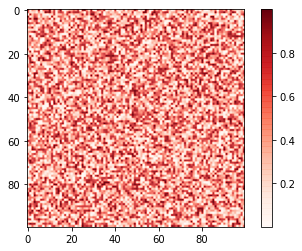

In [77]:
ncolors = 256
# get cmap
color_array = plt.get_cmap('Reds')(range(ncolors))
print(color_array.shape)
print(color_array)

# change alpha values
color_array[:, -1] = np.linspace(0.3, 1, ncolors)

# create colormap object
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

map_object = LinearSegmentedColormap.from_list(name="Reds_transp", colors=color_array)

# register the colormap object
plt.register_cmap(cmap=map_object)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap='Reds_transp')
plt.colorbar(mappable=h)

In [78]:
print(color_array)

[[1.         0.96078431 0.94117647 0.3       ]
 [0.99987697 0.95820069 0.93748558 0.3027451 ]
 [0.99975394 0.95561707 0.93379469 0.3054902 ]
 ...
 [0.41917724 0.00369089 0.05294887 0.9945098 ]
 [0.4115494  0.00184544 0.05196463 0.9972549 ]
 [0.40392157 0.         0.05098039 1.        ]]


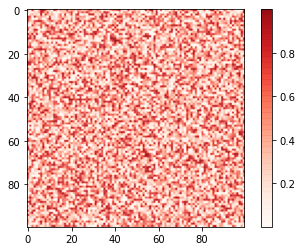

In [79]:
def trunc_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list('trunc({n}, {a:.2f}, {b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds_transp')
new_cmap = trunc_colormap(cmap, 0.0, .9)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap=new_cmap)
plt.colorbar(mappable=h)

In [80]:
print("baseline dimensions: ", baseline.shape)
print("hosp dimensions: ", hosp.shape)

baseline dimensions:  (250, 5, 356)
hosp dimensions:  (250,)


In [81]:
baseline[0, 1, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [82]:
params = {"axes.labelcolor":"slategrey"}
plt.rcParams.update(params)
cmap = plt.cm.get_cmap("Blues")
blue = cmap(200)

from tqdm import tqdm

for time_step in tqdm(range(1,25)):
    
    norge_geojson_3857['exposed'] = baseline[time_step-1, 1, :]
    
    #plot
    fig, ax = plt.subplots(figsize=(14,14), dpi=72)
    norge_geojson_3857.loc[norge_geojson_3857.index==84, 'exposed'] = max_exp_val + 1
    norge_geojson_3857.plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5, linewidth=0.5, zorder=2)
    norge_geojson_3857.plot(ax=ax, column='exposed', cmap=new_cmap, zorder=3)
    # add background
    # ctx.add_basemap(ax, attribution="", source=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
    
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')
    plt.tight_layout()
    
    inset_ax = fig.add_axes([0.6, 0.14, 0.37, 0.27])
    inset_ax.patch.set_alpha(0.5)
    
    inset_ax.plot(baseline[:time_step, 0].sum(axis=1), label="susceptible", color=blue, ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 1].sum(axis=1), label="exposed", color='g', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 2].sum(axis=1), label="infectious", color='r', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 3].sum(axis=1), label="recovered", color='y', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(hosp[:time_step], label="hospitalised", color='purple', ls='-', lw=1.5, alpha=0.8)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=50, alpha=0.2)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=20, alpha=0.8)
    
    inset_ax.fill_between(np.arange(0, time_step), np.maximum(baseline[:time_step, 0].sum(axis=1), \
                                                             baseline[:time_step, 3].sum(axis=1)), alpha=0.035, color='r')
    inset_ax.plot([time_step, time_step], [0, max(baseline[(time_step-1), 0].sum(), \
                                              baseline[(time_step-1), 3].sum())], ls='--', lw=0.7, alpha=0.8, color='r')
    
    inset_ax.set_ylabel('Population', size=18, alpha=1, rotation=90)
    inset_ax.set_xlabel('Days', size=18, alpha=1)
    inset_ax.yaxis.set_label_coords(-0.15, 0.55)
    inset_ax.tick_params(direction='in', size=10)
    inset_ax.set_xlim(-4, 254)
    inset_ax.set_ylim(-24000, 6024000)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    inset_ax.grid(alpha=0.4)
    
    inset_ax.spines['right'].set_visible(False)
    inset_ax.spines['top'].set_visible(False)
    
    inset_ax.spines['left'].set_color('darkslategrey')
    inset_ax.spines['bottom'].set_color('darkslategrey')
    inset_ax.tick_params(axis='x', colors='darkslategrey')
    inset_ax.tick_params(axis='y', colors='darkslategrey')
    plt.legend(prop={'size':14, 'weight':'light'}, framealpha=0.5)
    plt.title("Norway Covid-19 spreading on day: {}".format(time_step), fontsize=18, color= 'dimgray')
    plt.savefig("plots/plots_municipalities/flows_{}.jpg".format(time_step), dpi=fig.dpi)
    plt.close()

100%|██████████| 24/24 [00:53<00:00,  2.23s/it]


In [83]:
import re

def sort_in_order( l ):
    """ sorts a given iterable
    
    l : iterable to be sorted"""
    
    convert = lambda text: int(text) if text.isdigit() else text
    alphanumeric_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanumeric_key)

from os import listdir

filenames = listdir("plots/plots_municipalities/")
filenames = sort_in_order(filenames)
print(filenames)

['flows_1.jpg', 'flows_2.jpg', 'flows_3.jpg', 'flows_4.jpg', 'flows_5.jpg', 'flows_6.jpg', 'flows_7.jpg', 'flows_8.jpg', 'flows_9.jpg', 'flows_10.jpg', 'flows_11.jpg', 'flows_12.jpg', 'flows_13.jpg', 'flows_14.jpg', 'flows_15.jpg', 'flows_16.jpg', 'flows_17.jpg', 'flows_18.jpg', 'flows_19.jpg', 'flows_20.jpg', 'flows_21.jpg', 'flows_22.jpg', 'flows_23.jpg', 'flows_24.jpg']


In [84]:
import imageio
from tqdm import tqdm
with imageio.get_writer('gifs/gifs_municipaCovid_19_municipalities.gif', mode='I', fps=4) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('plots/plots_municipalities/{}'.format(filename))
        writer.append_data(image)

100%|██████████| 24/24 [00:04<00:00,  5.09it/s]
